# (Try to) identify signals of gentrification from Airbnb data

In [1]:
import os
import pandas as pd
import numpy as np
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import Point
import sys
import seaborn as sns
import geopandas as gpd
import matplotlib as mpl
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.colors as colors

sys.path.insert(0, '../')
from PlottingFunctions import *

def dominant_and_percentage_and_count(x):
    mode_vals = pd.Series.mode(x)
    if mode_vals.empty:
        mode_val = None
        pct = 0.0
    else:
        mode_val = mode_vals.iloc[0]
        pct = (x == mode_val).mean() * 100
    count = pd.Series.count(x)
    return pd.Series({'dominant_class': mode_val, 'dominant_pct': pct, 'count': count})

cmap = plt.get_cmap('viridis', 5)  # 5 discrete colors
plot_colors = [cmap(i) for i in range(5)]
plot_colors[4] = 'gold'

city='manchester'

### Get just Manchester LSOAs

In [2]:
lsoas =  gpd.read_file('../../../data/SpatialData/LSOAs_2011/LSOA_2011_EW_BSC_V4.shp')
manc_lads = ['Manchester', 'Rochdale', 'Bolton', 'Bury', 'Wigan', 'Oldham',  'Trafford', 'Salford', 'Tameside', 'Stockport']
manc_lads_pattern = '|'.join(manc_lads)
manchester_lsoas=lsoas[lsoas['LSOA11NMW'].str.contains(manc_lads_pattern)]

manchester_lsoas = manchester_lsoas.to_crs(epsg=27700)

# Define Manchester city centre point (in WGS84, then project)
city_centre_wgs84 = Point(-2.2426, 53.4808)  # approx lat/lon of Manchester city centre
city_centre_point = gpd.GeoSeries([city_centre_wgs84], crs='EPSG:4326').to_crs(epsg=27700).iloc[0]

# Filter polygons within a buffer distance (e.g., 3 km radius)
buffer = city_centre_point.buffer(6000)  # 3000 meters
central_lsoas = manchester_lsoas[manchester_lsoas.intersects(buffer)]
central_lsoas.reset_index(inplace=True)

## Get gentrification scores for each listing

In [3]:
base_dir = os.path.expanduser(f"../../../data/AirbnbData/airbnb-{city}/")
# score_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_one_per_lsoa_10.csv')
score_per_listing = pd.read_csv(base_dir + 'airbnb_gentrification_scores_new_03.csv')

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction'].map(mapping)
# Remove rows with an error
score_per_listing = score_per_listing[score_per_listing['explanation'] != 'ERROR']
score_per_listing = score_per_listing[["LSOA11NM", 'gentrification_prediction', 'explanation', 'gentrification_prediction_code', 'longitude',
                                              'latitude']]
score_per_listing['gentrification_prediction_code'] = score_per_listing['gentrification_prediction_code'].astype(int)
score_per_listing.head()

LSOA11NM gentrification_prediction  \
0  Bury 023C               Gentrifying   
1  Bury 023C               Established   
2  Bury 023C               Gentrifying   
3  Bury 023C                  Emerging   
4  Bury 023C               Established   

                                         explanation  \
0  The mention of Heaton Park, a large municipal ...   
1  The listing highlights the convenience of the ...   
2  The description of Prestwich as a "charming ar...   
3  The mention of "lovely independent restaurants...   
4  The listing focuses on the convenience of the ...   

   gentrification_prediction_code  longitude   latitude  
0                               3  -2.273020  53.531710  
1                               4  -2.269601  53.532356  
2                               3  -2.269350  53.532790  
3                               2  -2.271682  53.532365  
4                               4  -2.268370  53.534400

### Convert to geodataframe of scores per listing, reproject to BNG

In [4]:
score_per_listing['geometry'] = score_per_listing.apply(lambda row: Point(row['longitude'], row['latitude']), axis=1)
score_per_listing_gdf = gpd.GeoDataFrame(score_per_listing, geometry='geometry', crs="EPSG:4326")
score_per_listing_gdf = score_per_listing_gdf.set_crs(epsg=4326, allow_override=True)
score_per_listing_gdf = score_per_listing_gdf.to_crs(epsg=27700)

# # Keep only those in central LSOAs
score_per_listing_gdf = gpd.sjoin(
    score_per_listing_gdf,
    central_lsoas[["LSOA11NM", "geometry"]],
    how="inner",          # keep only matches
    predicate="within")

score_per_listing_gdf.head()

LSOA11NM_left gentrification_prediction  \
0     Bury 023C               Gentrifying   
1     Bury 023C               Established   
2     Bury 023C               Gentrifying   
3     Bury 023C                  Emerging   
4     Bury 023C               Established   

                                         explanation  \
0  The mention of Heaton Park, a large municipal ...   
1  The listing highlights the convenience of the ...   
2  The description of Prestwich as a "charming ar...   
3  The mention of "lovely independent restaurants...   
4  The listing focuses on the convenience of the ...   

   gentrification_prediction_code  longitude   latitude  \
0                               3  -2.273020  53.531710   
1                               4  -2.269601  53.532356   
2                               3  -2.269350  53.532790   
3                               2  -2.271682  53.532365   
4                               4  -2.268370  53.534400   

                        geometry  index_right LSOA11NM_right  
0  POINT (382000.213 403927.768)            0      Bury 023C  
1  POINT (382227.108 403998.771)            0      Bury 023C  
2  POINT (382243.927 404047.004)            0      Bury 023C  
3  POINT (382089.177 404000.353)            0      Bury 023C  
4   POINT (382309.56 404225.881)            0      Bury 023C

### Find which LSOA each listing is within

In [5]:
del score_per_listing_gdf['LSOA11NM_left']
score_per_listing_gdf.rename(columns = {'LSOA11NM_right':'LSOA11NM'}, inplace=True)
score_per_listing_gdf.reset_index(inplace=True, drop=True)
score_per_listing_gdf.head()

# get rid of LSOAs with no values
score_per_listing_gdf = score_per_listing_gdf[~score_per_listing_gdf['gentrification_prediction_code'].isna()]

### Check this spatially

## Create a dataframe with a count of the number of listings in each LSOA, and the modal score

In [6]:
per_LSOA_summary = (
    score_per_listing_gdf
    .groupby("LSOA11NM")["gentrification_prediction_code"]
    .apply(dominant_and_percentage_and_count)
    .unstack()
    .reset_index())

per_LSOA_summary = central_lsoas[['LSOA11NM', 'geometry']].merge(per_LSOA_summary, on='LSOA11NM')
per_LSOA_summary = per_LSOA_summary[per_LSOA_summary['dominant_class'].notnull()]
per_LSOA_summary['dominant_class'] = per_LSOA_summary['dominant_class'].astype(int)

In [7]:
my_colors = [cmap(i) for i in range(5)]
color_map = dict(zip(range(5), my_colors))
score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)
score_per_listing_gdf['color']= score_per_listing_gdf['gentrification_prediction_code'].map(color_map)
per_LSOA_summary['color']= per_LSOA_summary['dominant_class'].map(color_map)

In [8]:
fig,ax=plt.subplots(figsize=(10,10))

# Plot using the 'color' column directly
per_LSOA_summary_wm = per_LSOA_summary.to_crs(epsg=3857)
per_LSOA_summary_wm.plot(color=per_LSOA_summary_wm['color'], alpha=1, ax=ax, edgecolor='black')

score_per_listing_gdf_wm = score_per_listing_gdf.to_crs(epsg=3857)
score_per_listing_gdf_wm.plot(color=score_per_listing_gdf_wm['color'], ax=ax, legend=True, alpha=1, edgecolor='black', markersize=10);

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=score_per_listing_gdf_wm.crs)

ax.axis("off");
fig.savefig("../Figures/Manchester_modal_with_listings.png", bbox_inches='tight')

## Plot

Only specify one of 'column' or 'color'. Using 'color'.


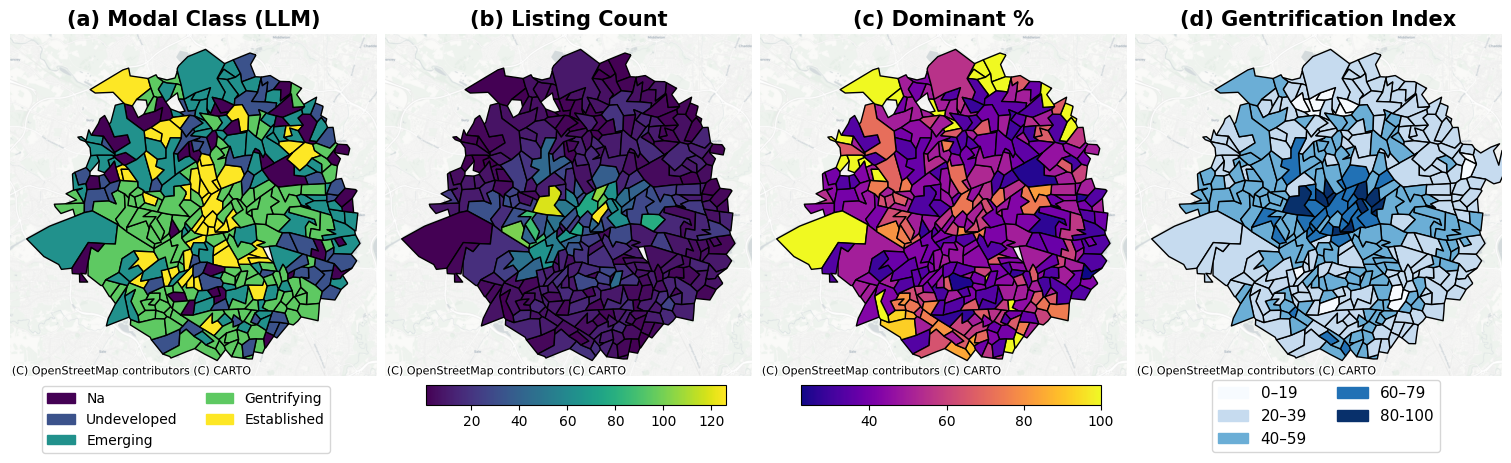

In [50]:
fig, axs = plt.subplots(ncols=4, figsize=(15, 5), constrained_layout=True)

per_LSOA_summary = per_LSOA_summary.to_crs(epsg=3857)

# ---- (a) Modal class ----
per_LSOA_summary.plot(
    "dominant_class", alpha=1, ax=axs[0], edgecolor='black', legend=False)
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[0].set_title("(a) Modal Class (LLM)", fontweight='bold', fontsize=15)
axs[0].axis("off")

# Legend for modal class
mapping = {'Na': 0, 'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
patches_llm = [
    mpatches.Patch(
        color=per_LSOA_summary.loc[per_LSOA_summary["dominant_class"] == k, "color"].iloc[0],
        label=label
    ) for k, label in class_labels.items()
]
fig.legend(
    handles=patches_llm,
    loc='lower center',
    bbox_to_anchor=(0.12, -0.01),
    frameon=True,
    ncol=len(patches_llm)//2,
    prop={'size': 10})

xlim, ylim = axs[0].get_xlim(), axs[0].get_ylim()

# ---- (b) Listing count ----
vmin, vmax = per_LSOA_summary['count'].min(), per_LSOA_summary['count'].max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.cm.viridis

per_LSOA_summary.plot(
    "count", alpha=1, ax=axs[1], edgecolor='black', legend=False, cmap=cmap)
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[1].set_title("(b) Listing Count", fontweight='bold', fontsize=15)
axs[1].axis("off")

# Colorbar manually
cbar_ax = fig.add_axes([0.28, 0.1, 0.2, 0.04])  # [left, bottom, width, height]
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', label="")

# ---- (c) Dominant % ----
vmin2, vmax2 = per_LSOA_summary['dominant_pct'].min(), per_LSOA_summary['dominant_pct'].max()
norm2 = colors.Normalize(vmin=vmin2, vmax=vmax2)
cmap2 = plt.cm.plasma

per_LSOA_summary.plot(
    "dominant_pct", alpha=1, ax=axs[2], edgecolor='black', legend=False, cmap=cmap2)
ctx.add_basemap(axs[2], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[2].set_title("(c) Dominant %", fontweight='bold', fontsize=15)
axs[2].axis("off")

# Colorbar manually
cbar_ax2 = fig.add_axes([0.53, 0.1, 0.2, 0.04])
# cbar_ax2 = fig.add_axes([0.67, -0.01, 0.28, 0.04])  # [left, bottom, width, height]
sm2 = plt.cm.ScalarMappable(norm=norm2, cmap=cmap2)
sm2.set_array([])
fig.colorbar(sm2, cax=cbar_ax2, orientation='horizontal', label="")

# ---- (d) Dominant % ----
gi_colors = ["#f7fbff", "#c6dbef", "#6baed6", "#2171b5", "#08306b"]  # light->dark
g_index_gdf['color'] = g_index_gdf['gi_n_cat'].map({i+1: c for i, c in enumerate(gi_colors)})

g_index_gdf.plot(
    "gi_n_cat", alpha=1, ax=axs[3], edgecolor='black', legend=False, color=g_index_gdf['color'])
ctx.add_basemap(axs[3], source=ctx.providers.CartoDB.Positron, crs=g_index_gdf.crs)
axs[3].set_title("(d) Gentrification Index", fontweight='bold', fontsize=15)
axs[3].axis("off")

# Legend for gi_n_cat
labels_gi = ["0–19", "20–39", "40–59", "60–79", "80-100"]
patches_gi = [mpatches.Patch(color=c, label=l) for c, l in zip(gi_colors, labels_gi)]
fig.legend(handles=patches_gi, loc='lower center', bbox_to_anchor=(0.88, -0.01),
    frameon=True, ncol=2,  prop={'size': 11})

# ... after plotting (d)
axs[3].set_xlim(xlim)
axs[3].set_ylim(ylim)

plt.savefig("../Figures/Manchester_LLM-scores.png", bbox_inches='tight', dpi=300)
plt.show()


### Gentrification index spatial plot

In [10]:
g_index = pd.read_csv("../../../data/GentrificationIndex/ManchesterIndex/manc_index.csv") 
g_index_gdf = central_lsoas[['LSOA11NM', 'geometry']].merge(g_index, on='LSOA11NM')

In [11]:
# g_index_gdf = g_index_gdf.to_crs(epsg=3857)
# g_index_gdf.head()

In [12]:
# per_LSOA_summary = per_LSOA_summary.to_crs(epsg=3857)
# per_LSOA_summary.head()

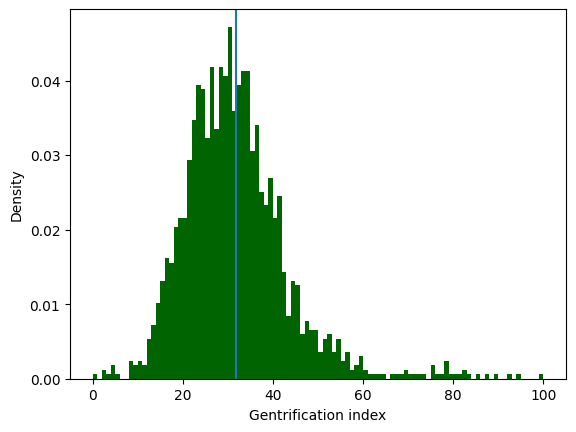

In [13]:
plt.hist(g_index['gi_n'], bins=100, color='darkgreen', density=True);
plt.axvline(np.mean(g_index['gi_n']))
plt.ylabel('Density')
plt.xlabel('Gentrification index');
plt.savefig("../Figures/Manchester_GI_histogram.png", bbox_inches = 'tight')
np.mean(g_index['gi_n']);

In [14]:
# fig, axs = plt.subplots(ncols = 2, figsize=(10, 10), sharey=True, sharex=True)

# # Plot the data
# g_index_gdf.plot(column='gi_n',cmap='viridis',vmin=20,vmax=60,ax=axs[0],legend=False)

# # Create divider and color axis
# divider = make_axes_locatable(axs[0])
# cax = divider.append_axes("right", size="5%", pad=0.05)

# # Create ScalarMappable for colorbar
# norm = colors.Normalize(vmin=20, vmax=60)
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm._A = []  # dummy array

# # Add colorbar
# cbar = plt.colorbar(sm, cax=cax)
# cbar.set_label("GI Index")

# ########### axis2
# g_index_gdf.plot('gi_n', ax=axs[1])

# # Create divider and color axis
# divider = make_axes_locatable(axs[1])
# cax = divider.append_axes("right", size="5%", pad=0.05)

# # Create ScalarMappable for colorbar
# norm = colors.Normalize(vmin=0, vmax=100)
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
# sm._A = []  # dummy array
# # Add colorbar
# cbar = plt.colorbar(sm, cax=cax)
# cbar.set_label("GI Index")

# axs[0].axis("off")
# axs[1].axis("off");

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


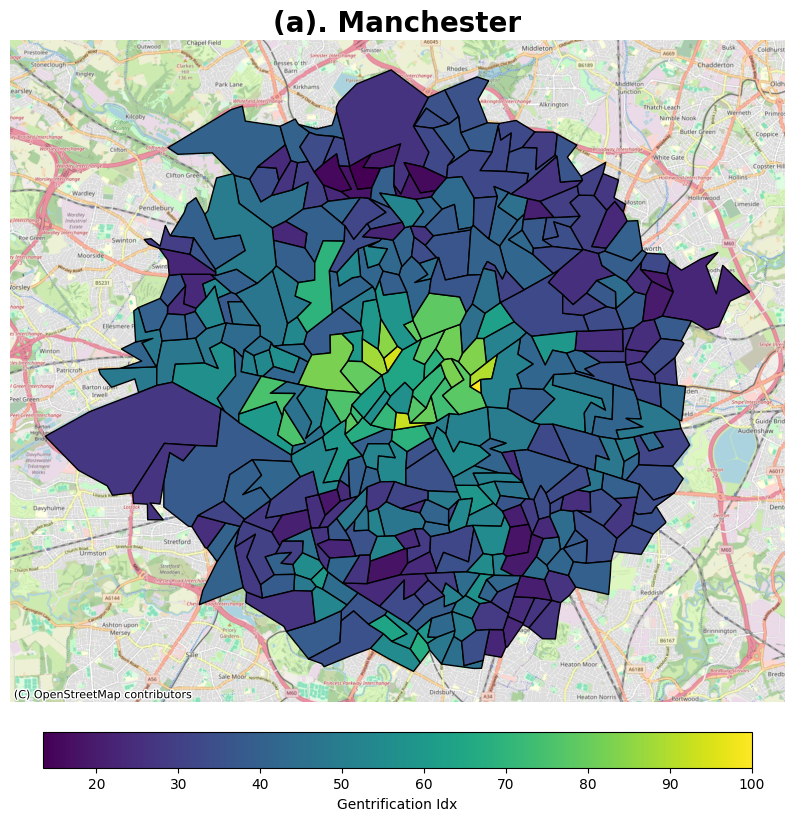

In [15]:
fig, axs = plt.subplots(figsize=(10, 10))

g_index_gdf = g_index_gdf.to_crs(epsg=3857)
g_index_gdf.plot(
    'gi_n',
    ax=axs,
    legend=False,
    edgecolor='black')

ctx.add_basemap(axs, source=ctx.providers.OpenStreetMap.Mapnik, crs=per_LSOA_summary.crs)
# Create colorbar manually
norm = mpl.colors.Normalize(vmin=g_index_gdf['gi_n'].min(), vmax=g_index_gdf['gi_n'].max())
cmap = plt.cm.get_cmap('viridis')

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs,
    orientation='horizontal',
    fraction=0.046,  # size of colorbar relative to plot
    pad=0.04)
cbar.set_label("Gentrification Idx")
axs.set_title("(a). Manchester", fontsize=20, fontweight='bold')
axs.axis("off");
fig.savefig("../Figures/Manchester_GI.png", bbox_inches='tight', pad_inches=0.2)

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


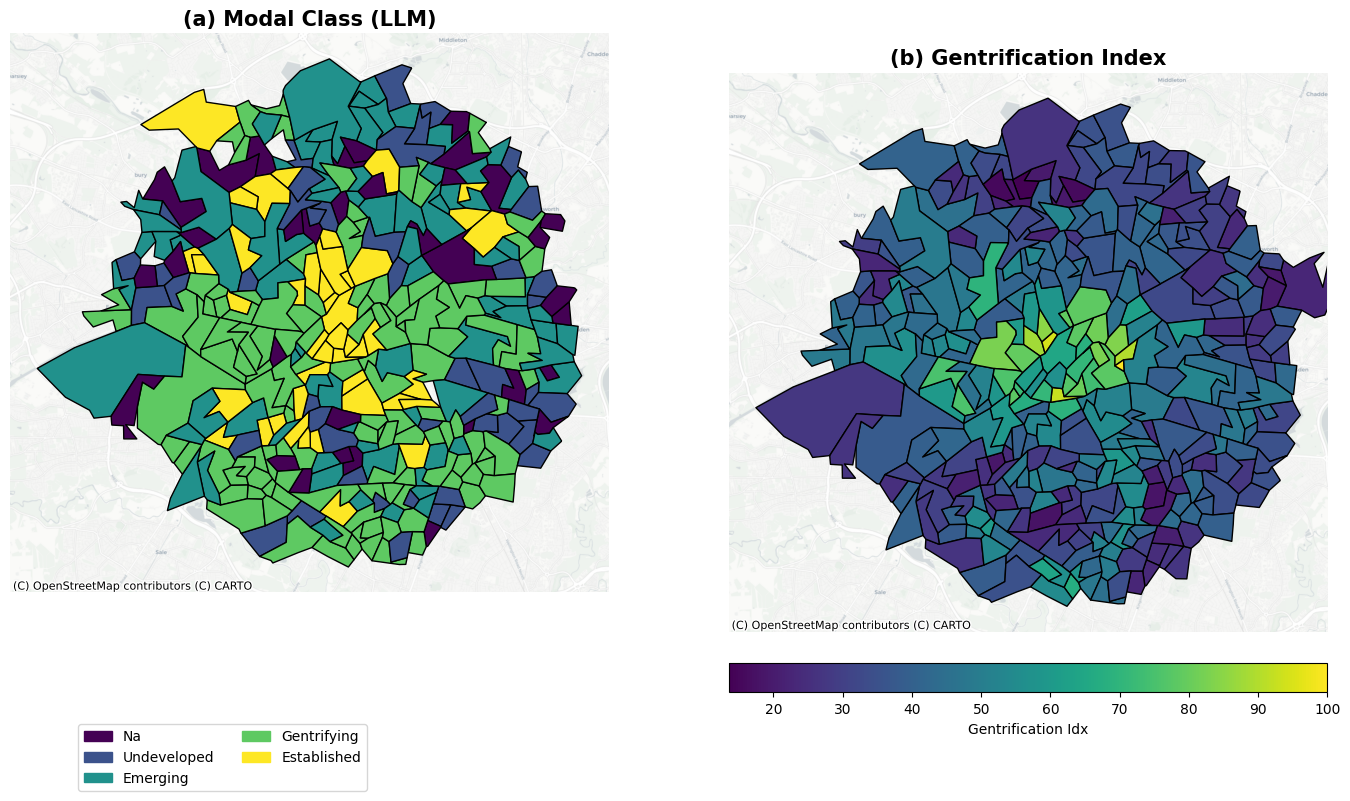

In [16]:
fig, axs = plt.subplots(ncols=2, figsize=(17, 10), sharey=True, sharex=True)

# (a) LLM map
per_LSOA_summary.plot(
    "dominant_class", alpha=1, ax=axs[0],  edgecolor='black', legend=False)
    # legend_kwds={"label": "ModalClass", **legend_opts})
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[0].set_title("(a) Modal Class (LLM)", fontweight='bold', fontsize=15)
axs[0].axis("off")

mapping = {'Na': 0,'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
class_labels = {v: k for k, v in mapping.items()}
patches_llm = [mpatches.Patch(color=per_LSOA_summary.loc[per_LSOA_summary["dominant_class"] == k, "color"].iloc[0], 
                              label=label) for k, label in class_labels.items()]

# (b) GI map
g_index_gdf = g_index_gdf.to_crs(epsg=3857)
g_index_gdf.plot(
    'gi_n',
    ax=axs[1],
    legend=False,
    edgecolor='black')

ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
# Create colorbar manually
norm = mpl.colors.Normalize(vmin=g_index_gdf['gi_n'].min(), vmax=g_index_gdf['gi_n'].max())
cmap = plt.cm.get_cmap('viridis')

cbar = fig.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
    ax=axs[1],
    orientation='horizontal',
    fraction=0.046,  # size of colorbar relative to plot
    pad=0.04         # gap between plot and colorbar
)
cbar.set_label("Gentrification Idx")
axs[1].axis("off")
axs[1].set_title("(b) Gentrification Index", fontweight='bold', fontsize=15)

# --- Create legends & colorbar at the bottom ---
# 1. LLM legend
leg1 = fig.legend(handles=patches_llm, loc='lower center', bbox_to_anchor=(0.25, 0.01),
                  frameon=True, ncol=len(patches_llm)//2, prop={'size': 10})

In [17]:
bins = [0, 15, 30, 45, 60, float('inf')]
bins = [0, 20, 40, 60, 80, float('inf')]
labels = [1, 2, 3, 4, 5]

g_index_gdf["gi_n_cat"] = pd.cut(
    g_index_gdf["gi_n"],
    bins=bins,
    labels=labels,
    right=False  # include the left edge, exclude the right edge
).astype(int)

Only specify one of 'column' or 'color'. Using 'color'.


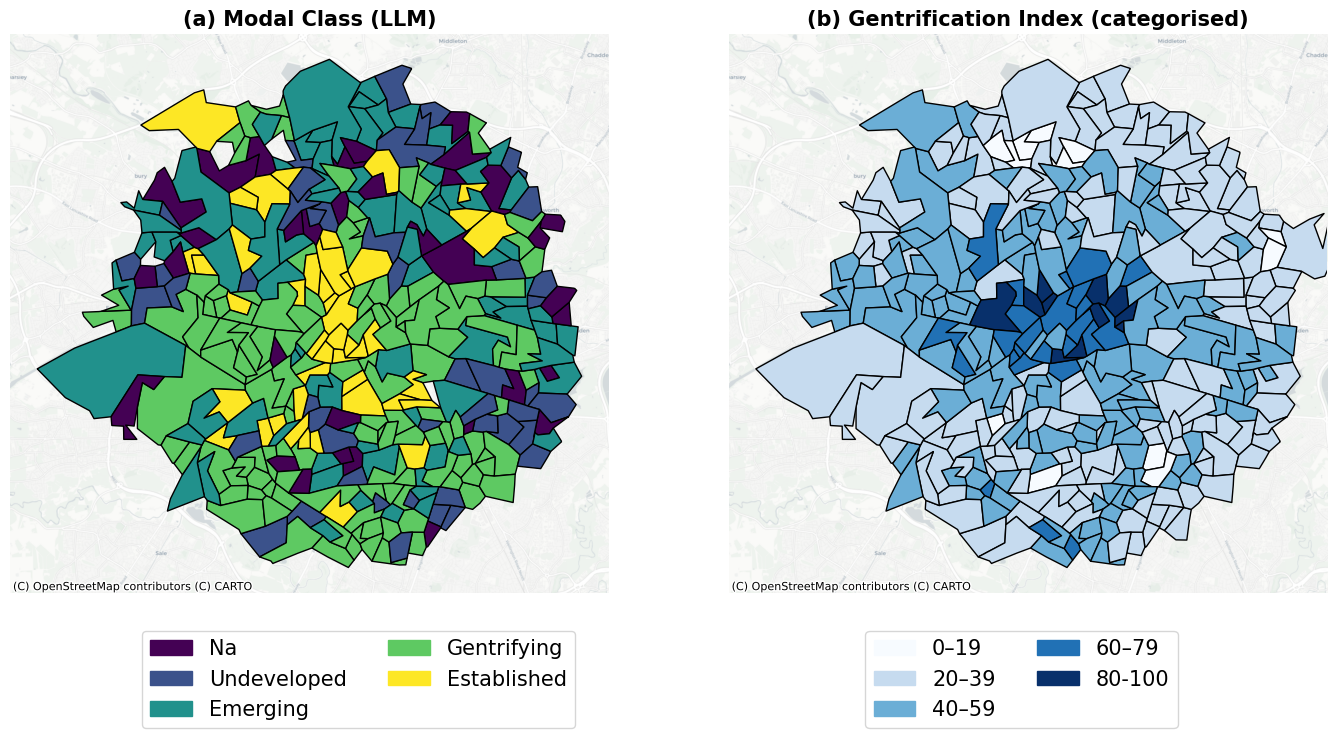

In [18]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx
import pandas as pd

# Ensure both datasets are in Web Mercator
per_LSOA_summary = per_LSOA_summary.to_crs(epsg=3857)
g_index_gdf = g_index_gdf.to_crs(epsg=3857)

fig, axs = plt.subplots(ncols=2, figsize=(17, 10), sharey=True, sharex=True)

########################### (a) LLM map
per_LSOA_summary.plot(
    "dominant_class", alpha=1, ax=axs[0], edgecolor='black', legend=False)
ctx.add_basemap(axs[0], source=ctx.providers.CartoDB.Positron, crs=per_LSOA_summary.crs)
axs[0].set_title("(a) Modal Class (LLM)", fontweight='bold', fontsize=15)
axs[0].axis("off")

# Legend for dominant_class
mapping = {'Na': 0, 'Undeveloped': 1, 'Emerging': 2, 'Gentrifying': 3, 'Established': 4}
patches_llm = [
    mpatches.Patch(
        color=per_LSOA_summary.loc[per_LSOA_summary["dominant_class"] == key, "color"].iloc[0],
        label=label
    )
    for label, key in mapping.items()
]
fig.legend(
    handles=patches_llm,
    loc='lower center',
    bbox_to_anchor=(0.33, 0.07),
    frameon=True,
    ncol=len(patches_llm)//2,
    prop={'size': 15}
)

###################### (b) GI map
# Assign colors for gi_n_cat
gi_colors = ["#f7fbff", "#c6dbef", "#6baed6", "#2171b5", "#08306b"]  # light->dark
g_index_gdf['color'] = g_index_gdf['gi_n_cat'].map({i+1: c for i, c in enumerate(gi_colors)})

g_index_gdf.plot(
    "gi_n_cat", alpha=1, ax=axs[1], edgecolor='black', legend=False, color=g_index_gdf['color'])
ctx.add_basemap(axs[1], source=ctx.providers.CartoDB.Positron, crs=g_index_gdf.crs)
axs[1].set_title("(b) Gentrification Index (categorised)", fontweight='bold', fontsize=15)
axs[1].axis("off")

# Legend for gi_n_cat
labels_gi = ["0–19", "20–39", "40–59", "60–79", "80-100"]
patches_gi = [mpatches.Patch(color=c, label=l) for c, l in zip(gi_colors, labels_gi)]
fig.legend(
    handles=patches_gi,
    loc='lower center',
    bbox_to_anchor=(0.72, 0.07),
    frameon=True,
    ncol=2,
    prop={'size': 15}
)

fig.savefig("../Figures/Manchester_GI-scores.png", bbox_inches='tight')
plt.show()
